# Image Recognition


## Importing Necessary Libraries 


In [1]:
# Importing Libraries

import zipfile 

import pandas as pd

import numpy as np

import random as random 

import torch

import torch.nn as nn

import torch.nn.functional as F

import torch.optim as optim

from torchvision import datasets, transforms

from torch.utils.data import DataLoader,TensorDataset , ConcatDataset

import matplotlib.pyplot as plt

import seaborn as sns

from PIL import Image 


## Loading the Given Data set and Understanding it 


In [2]:
# Reading The data into A dataframe to Look at the data 


metaData = pd.read_csv("/kaggle/input/torch-it-up/dataset/metaData.csv")

test = pd.read_csv("/kaggle/input/torch-it-up/dataset/test.csv")

train = pd.read_csv("/kaggle/input/torch-it-up/dataset/train.csv")


## Looking Through the data 

In [3]:
# Test data 

test.sample(10)

,image_path,user_id,example_id
12567,data/v2-99417.png,10,99417
15504,data/v2-75536.png,10,75536
7675,data/v2-98973.png,16925,98973
27614,data/v2-127277.png,16925,127277
18387,data/v2-140924.png,16925,140924
1539,data/v2-132409.png,6483,132409
25941,data/v2-29020.png,16925,29020
28819,data/v2-107438.png,16925,107438
4223,data/v2-38103.png,16925,38103
4778,data/v2-93063.png,16925,93063


In [4]:
# Meta Data 
metaData.sample(10)

,example_id,image_path,symbol_name
99276,141565,data/v2-141565.png,\emptyset
10765,131693,data/v2-131693.png,\lceil
122792,138267,data/v2-138267.png,\infty
131374,140247,data/v2-140247.png,\diamondsuit
114574,163893,data/v2-163893.png,\mars
32812,55981,data/v2-55981.png,\int
7513,60669,data/v2-60669.png,\geq
81244,90947,data/v2-90947.png,\oiint
48777,50836,data/v2-50836.png,\chi
24154,62693,data/v2-62693.png,\subseteq


In [5]:
# train data 
train.sample(10)

,image_path,label,latex,user_id,example_id
99234,data/v2-77399.png,517,\triangleleft,16925,77399
102705,data/v2-159075.png,1066,\mathds{R},16925,159075
126686,data/v2-77365.png,517,\triangleleft,10,77365
85308,data/v2-96341.png,605,\perp,16925,96341
59962,data/v2-138228.png,944,\infty,16925,138228
101000,data/v2-160239.png,1074,\mathds{Z},16925,160239
99690,data/v2-62139.png,190,\supset,16925,62139
123321,data/v2-14595.png,968,\square,16925,14595
17871,data/v2-68485.png,261,\},6483,68485
52780,data/v2-86039.png,537,\circ,16925,86039


In [6]:
train['label']

0         786
1         194
2         951
3         921
4         531
         ... 
134581    884
134582    968
134583    116
134584    262
134585    513
Name: label, Length: 134586, dtype: int64

## Checking for any null values in the data 


In [7]:
train.columns

Index(['image_path', 'label', 'latex', 'user_id', 'example_id'], dtype='object')

In [8]:
train.isna().sum()

image_path    0
label         0
latex         0
user_id       0
example_id    0
dtype: int64

In [9]:
test.isna().sum()

image_path    0
user_id       0
example_id    0
dtype: int64

In [10]:
metaData.isna().sum()

example_id     0
image_path     0
symbol_name    0
dtype: int64

## Has many numbered labels missing so ahve to map them and demap them at submission

In [11]:
unique_labels = sorted(train["label"].unique(), key=lambda x: int(x))  # Sort numerically if labels are integers
i = 0 
changed_labels ={}
while (i < len(unique_labels)):
    changed_labels [i] = unique_labels[i]
    i+=1
i = 0
label_map = {v: k for k, v in changed_labels.items()} 

train["label"] = train["label"].map(label_map)


## Checking weather if lets say if each user in this has like ample no of training examples then i can train them differntly for differnet users so that when given the same userid i will train with that itself 

In [12]:
user_example_counts = train.groupby('user_id').size()
user_example_counts

user_id
10        3143
14           1
15         555
23          38
25           2
          ... 
124916      46
125926      72
126638       2
128674       1
130087       2
Length: 429, dtype: int64

## Looking at the data we cant train separately for each user so 

## Defining transformation for the images to be read 


### Isnt required as in question it is mentioned that data is already grayscaled and noramlised and ready to  train deeplearning models

In [13]:
#{ Converting the images into tensor and then normalising the data varying from 0 to 255 in terms of -1 to 1 }
# I got to know that they were already normalised and all so i didnt scrap my existing code just commented it out 

# we only need to convert them into tensors 

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    #transforms.Normalize((0.5,), (0.5,))
])

In [14]:
# Checking for the max value of label 

train['label'].max()

368

## Data Augmentation

In [15]:
# Checking for labels with less than 100 training examples

train['label'].value_counts()[lambda x: x <100]

label
318    99
29     99
235    98
244    97
259    97
       ..
23     43
4      43
51     42
356    42
357    41
Name: count, Length: 102, dtype: int64

Well we can do see that there are many labels with less than 100 training exmaples to keep it fair and to improve my models accuracy lets just augment images of the labels that have less than 100 training examples 

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Applying the transformation logic for augmentation for the image dataset 
augment = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=1),  
    transforms.ToTensor()
])

# Get data with less than 100 labels and then get them all in a list

label_counts = train['label'].value_counts()
labels_to_augment = label_counts[label_counts < 100].index

# Two empty datasets (lists) to store results 
augmented_images = []
augmented_labels = []

# Looping through all the labels to augment and creating new data 
for label in labels_to_augment:
    subset = train[train['label'] == label].iloc[:1]  # Select only one image per label
    
    for index, row in subset.iterrows():
        image = Image.open("/kaggle/input/torch-it-up/dataset/Dataset_Image/Dataset_Image/" + row['image_path']).convert("L")
        
        # Generate just enough augmented images to reach 100 examples
        needed = 200 - label_counts[label]

        for _ in range(needed):
            # Apply augmentation
            aug_img = augment(image)
            augmented_images.append(aug_img)
            augmented_labels.append(label)

# Convert tensors into a Tensor as a whole


In [17]:
augmented_images = torch.stack(augmented_images).to(device)

# Converting the augmented_labels from dtype lists to tensor 

augmented_labels = torch.tensor(augmented_labels , dtype = torch.long).to(device)

In [18]:
print(f"Augmented Images Shape: {augmented_images.shape}")  # Should be [N, 1, 32, 32]
print(f"Augmented Labels Shape: {augmented_labels.shape}") 
print(f"Original Training Data: {train.shape}")

Augmented Images Shape: torch.Size([13484, 1, 32, 32])
Augmented Labels Shape: torch.Size([13484])
Original Training Data: (134586, 5)


## Checking if The Augemntation Worked 

In [19]:
# Checking My new data 

# Convert tensors to Python sets for easy comparison
unique_augmented_labels = set(augmented_labels.tolist())
labels_to_augment_set = set(labels_to_augment)

# Check which labels are missing
missing_augmented_labels = labels_to_augment_set - unique_augmented_labels

# Print results
if len(missing_augmented_labels) > 0:
    print("Some Lables are surely Missing They are ", missing_augmented_labels)
else:
    print("Successfull Mate ")


Successfull Mate 


## Concatenating augemnted data and existing data and oading them 

In [20]:
# # Getting my training data set ready 

# training_images = [transform(Image.open("/kaggle/input/torch-it-up/dataset/Dataset_Image/Dataset_Image/" + path).convert("L")) for path in train["image_path"]]

# # Convert labels to tensor 
# # I defined it as int16 cause max value was only 1400

# training_labels = torch.tensor(train["label"].values, dtype=torch.long)  


# As it takes very long ihave downloaded from my previous excutions 

training_images , training_labels = torch.load('/kaggle/input/data-train/processed_training_data.pt')

training_images = training_images.to(device)
training_labels = training_labels.to(device)

# creatinga tensordataset out of tensors i have 
training_set = TensorDataset(training_images, training_labels)

augmented_set = TensorDataset(augmented_images, augmented_labels)

# Merge both datasets using ConcatDataset
train_dataset = ConcatDataset([training_set, augmented_set])


<ipython-input-20-28401da3ee96>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_images , training_labels = torch.load('/kaggle/input/data-train/processed_training

In [21]:
# Loading data to the loader 

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)



In [22]:
for images, labels in train_loader:
    if images.shape[1] !=1 :
        print("stop")
print("done")

done


## Loading Test_data into DataLoader 

In [23]:
# Getting my testing data set ready
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor()
])
# testing_images = [test_transform(Image.open("/kaggle/input/torch-it-up/dataset/Dataset_Image/Dataset_Image/" + path)) for path in test["image_path"]]

## I have Just Noticed That even if max is 1400 "The label Numebr " we only do have 369 labels 

In [24]:
print("Unique labels in dataset:", train["label"].nunique())

Unique labels in dataset: 369


In [25]:

testing_images = torch.load('/kaggle/input/testing-data-tensor/processed_training_data (1).pt')

# Convert labels to tensor 

example_ids = torch.tensor(test["example_id"].values, dtype=torch.long)  

# creatinga tensordataset out of tensors i have 
testing_dataset = TensorDataset(testing_images, example_ids)

#Loading all data into train_loader 

test_loader = DataLoader(testing_dataset, batch_size=64)



<ipython-input-25-890550f98ca8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  testing_images = torch.load('/kaggle/input/testing-data-tensor/processed_training_data (1).p

## Optional (Part If Augmentation Not needed )

In [26]:
# Getting ,y training data set ready 

# training_images = [transform(Image.open("/kaggle/input/torch-it-up/dataset/Dataset_Image/Dataset_Image/" + path)) for path in train["image_path"]]

# # Convert labels to tensor 
# # I defined it as int16 cause max value was only 1400

# training_labels = torch.tensor(train["label"].values, dtype=torch.int16)  

# # creatinga tensordataset out of tensors i have 
# training_set = TensorDataset(torch.stack(training_images), training_labels)

# trainloader = DataLoader(training_set, batch_size=256, shuffle=True)

# # Checking for data in a batch 
# for images, labels in trainloader:
#     print(images.shape)  
#     print(labels.shape)  
#     break

## Visualising Some Samples from the training_data set 

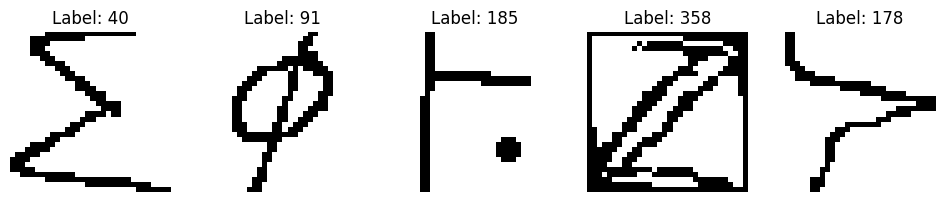

In [27]:
# Visualizing some samples from the dataset

def show_images(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for i in range(5):
        axes[i].imshow(images[i][0].cpu().numpy(), cmap='gray')
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')
    plt.show()

show_images(train_loader)

## Defining Our Neural Network To work


How The Neural Network Works :-

    

In [28]:
# # class ConvNet(nn.Module):
#     # def __init__(self):
#     #     super(ConvNet, self).__init__()
#     #     self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
#     #     self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#     #     self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#     #     self.pool = nn.MaxPool2d(2, 2)
#     #     self.fc1 = nn.Linear(4 * 4 * 128, 128)
#     #     self.fc2 = nn.Linear(128, 369)

    
#     # def forward(self, x):
#     #     x = self.pool(F.relu(self.conv1(x)))
#     #     x = self.pool(F.relu(self.conv2(x)))
#     #     x = self.pool(F.relu(self.conv3(x)))
#     #     x = x.view(-1, 4 * 4 * 128)
#     #     x = F.relu(self.fc1(x))
#     #     x = self.fc2(x)
#     #     return F.log_softmax(x, dim=1)



# class ConvNet(nn.Module):
#     def __init__(self):
#         super(ConvNet, self).__init__()
        
#         # Convolutional Layers
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(32)  
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(64)  
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.bn3 = nn.BatchNorm2d(128)  
        
#         # Pooling
#         self.pool = nn.MaxPool2d(2, 2)
#         self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
#         self.fc1 = nn.Linear(4 * 4 * 128, 256)  
#         self.dropout1 = nn.Dropout(0.4)  
#         self.fc2 = nn.Linear(256, 128)  
#         self.dropout2 = nn.Dropout(0.3)
#         self.fc3 = nn.Linear(128, 369)  
        
#     def forward(self, x):
#         # Conv Block 1
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
#         # Conv Block 2
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
#         # Conv Block 3
#         x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
#         # Adaptive Pooling
#         x = self.adaptive_pool(x)
        
#         # Flatten
#         x = x.view(-1, 4 * 4 * 128)
        
#         # Fully Connected Layers
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)  # Dropout after FC1
#         x = F.relu(self.fc2(x))
#         x = self.dropout2(x)  # Dropout after FC2
#         x = self.fc3(x)  # No activation (CrossEntropyLoss expects raw logits)
        
#         return x  # Removed log_softmax since loss function handles it


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)  
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)  
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)  
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc1 = nn.Linear(4 * 4 * 256, 512)  
        self.dropout1 = nn.Dropout(0.5)  
        self.fc2 = nn.Linear(512, 256)  
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, 128)  
        self.fc4 = nn.Linear(128, 369)  
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.adaptive_pool(x)
        x = x.view(-1, 4 * 4 * 256)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x


## Initalsing My neural Network Model 

In [29]:
model = ConvNet()

## Optimiser and Loss Function

In [30]:
#  Optimizer and Loss Function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)  # Reduce LR every 10 epochs
criterion = nn.CrossEntropyLoss()

## Functions for Training The Model and evaluating the Model 

In [31]:
# Method To Initialise the Training of the Model
def train_model(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    correct_predictions = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        correct_predictions += (preds == labels).sum().item()

    accuracy = (correct_predictions / len(loader.dataset)) * 100
    return epoch_loss / len(loader), accuracy

## Training and validating the Model 

In [32]:
# Training and Validation Loop
num_epochs = 10  # Number of rounds to train the data
train_losses, train_accuracies = [], []  # Cache all the training values in a list
test_losses, test_accuracies = [], []   # Cache all the testing values in a list

In [33]:
for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

Epoch 1: Train Loss: 2.2837, Train Acc: 46.27%
Epoch 2: Train Loss: 1.1346, Train Acc: 68.20%
Epoch 3: Train Loss: 0.8666, Train Acc: 74.85%
Epoch 4: Train Loss: 0.7516, Train Acc: 77.62%
Epoch 5: Train Loss: 0.6801, Train Acc: 79.39%
Epoch 6: Train Loss: 0.6293, Train Acc: 80.65%
Epoch 7: Train Loss: 0.5879, Train Acc: 81.53%
Epoch 8: Train Loss: 0.5599, Train Acc: 82.24%
Epoch 9: Train Loss: 0.5354, Train Acc: 82.85%
Epoch 10: Train Loss: 0.5142, Train Acc: 83.29%


## Just cheking My mapping Cuase i did the Mapping Worng Initially 

## Training Again 

## Final Output File 

In [34]:
# import os 
# os.remove("submission.csv")

In [35]:
# Training and Validation Loop
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.7)

num_epochs = 10  # Number of rounds to train the data
train_losses, train_accuracies = [], []  # Cache all the training values in a list
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

Epoch 1: Train Loss: 0.4128, Train Acc: 86.04%
Epoch 2: Train Loss: 0.3872, Train Acc: 86.68%
Epoch 3: Train Loss: 0.3732, Train Acc: 87.02%
Epoch 4: Train Loss: 0.3635, Train Acc: 87.14%
Epoch 5: Train Loss: 0.3530, Train Acc: 87.46%
Epoch 6: Train Loss: 0.3447, Train Acc: 87.68%
Epoch 7: Train Loss: 0.3354, Train Acc: 87.87%
Epoch 8: Train Loss: 0.3309, Train Acc: 88.07%
Epoch 9: Train Loss: 0.3223, Train Acc: 88.16%
Epoch 10: Train Loss: 0.3143, Train Acc: 88.46%


In [36]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

In [37]:
num_epochs = 10  # Number of rounds to train the data
train_losses, train_accuracies = [], []  # Cache all the training values in a list
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

Epoch 1: Train Loss: 0.2847, Train Acc: 89.45%
Epoch 2: Train Loss: 0.2760, Train Acc: 89.61%
Epoch 3: Train Loss: 0.2727, Train Acc: 89.70%
Epoch 4: Train Loss: 0.2681, Train Acc: 89.84%
Epoch 5: Train Loss: 0.2669, Train Acc: 89.94%
Epoch 6: Train Loss: 0.2628, Train Acc: 90.06%
Epoch 7: Train Loss: 0.2600, Train Acc: 90.16%
Epoch 8: Train Loss: 0.2568, Train Acc: 90.34%
Epoch 9: Train Loss: 0.2553, Train Acc: 90.26%
Epoch 10: Train Loss: 0.2508, Train Acc: 90.45%


In [38]:
print("Hi")

Hi


In [39]:
## Get The Results and save into csv for further submisiion

model.eval()
predict = []
example_ids = []

with torch.no_grad():  
    for images, ex_ids in test_loader:  
        images = images.to(device)  
        outputs = model(images)
        predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()
        predict.extend(predicted_labels)
        example_ids.extend(ex_ids.numpy())  

# Convert predicted labels back to original IDs
reverse_label_map = {v: k for k, v in label_map.items()}  
original_predictions = [reverse_label_map[pred] for pred in predict]  

submission_df = pd.DataFrame({
    "example_id": example_ids,
    "predicted_label": original_predictions  
})

# Save the output labels to CSV
submission_df.to_csv("submission.csv", index=False)  

print("Completed Mate 🥰")

Completed Mate 🥰
